#Evaluation - id14061674

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time

### Load dataset

In [2]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [3]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.8 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

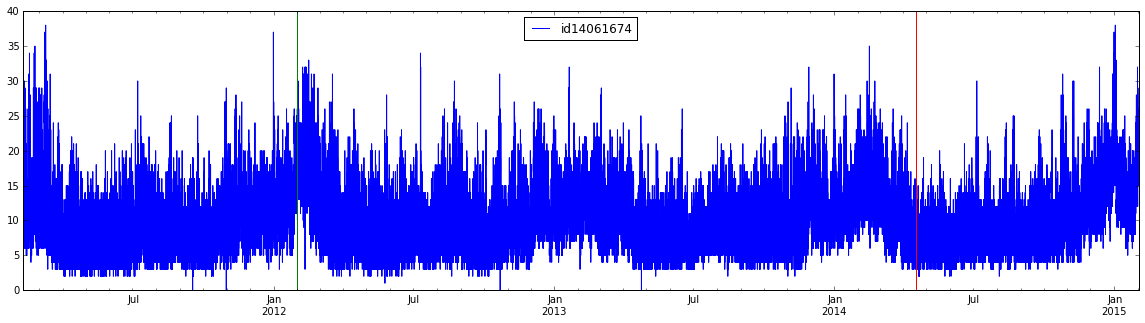

In [4]:
f = original_data[["id14061674"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

# Define Machine Learning Models and Data Sets

In [5]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
from neural_network import PyBrainNN

## Creating Feature Sets

In [6]:
autoregressive_ftrs = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay', 't2m_termin_roll_mean_m', 'shifted_Holiday', 
              'shifted_energija_gl', 'shifted_DayOfWeek', 'shifted_t2m_termin', 'p_roll_var_d', 'shifted_measurement_2d', 
              'measurement_roll_mean_m', 'p_roll_mean_m', 'rh_termin_roll_mean_w']

top10_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay']

In [7]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs

## Prediction Results

In [8]:
class NaiveModel:
    
    def __init__(self, target):
        self.target = target

In [9]:
baselines = [{'name': "Last value", 'init': "NaiveModel('measurement')"},
             {'name': "Previous day", 'init': "NaiveModel('shifted_measurement_1d')"},
             {'name': "Previous week", 'init': "NaiveModel('shifted_measurement_1w')"},
             #{'name': "Measurement average", 'init': "NaiveModel('measurement_avr')"},
            ]

models = [{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          {'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=10)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [{'name': "Baselines", 'ftrs': ar_ftrs},
             {'name': "AR", 'ftrs': ar_ftrs},
             {'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             {'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             {'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             {'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             {'name': "ALL", 'ftrs': all_ftrs},
             {'name': "TOP_20", 'ftrs': top20_ftrs},
             {'name': "TOP_10", 'ftrs': top10_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

In [10]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id14061674']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek, sensor_data.index.time], how = 'left')
        
        for horizon in range (1,25):
        #for horizon in range (1,4):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                if "shifted_HourOfDay" in data_set['ftrs']:
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else:
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features: ", X_test_dummy.shape
                                                           
                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                          X_train.shape, y_train.shape)

                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        
                        if verbose: print "\t\t\t-->Computing {}".format(baseline['name'])
                        bl = eval(baseline['init'])

                        for metric in error_metrics:
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[bl.target])
                            else:
                                error = metric['function'](y_test, testing_data[bl.target])

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                
                else:    
                    for model in models: 
                        # Initializing model
                        mdl = eval(model['init'])

                        # Model leraning
                        start = time.time() # Start measuring time
                        if model['name'] == "Ridge Regression":
                            mdl.fit(X_train_dummy, y_train_dummy)
                        else:
                            mdl.fit(X_train,y_train)
                        runtime = time.time() - start # Calculate runtime

                        if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])

                            if model['name'] == "Ridge Regression":
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                               y_test_dummy, mdl.predict(X_test_dummy))
                                else:
                                    error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                            else: 
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                               y_test, mdl.predict(X_test))
                                else:
                                    error = metric['function'](y_test, mdl.predict(X_test))

                            #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

Working with sensor: id14061674

	-->Prediction horizont: 1h. Shifting runtime: 15.46s

		-->Dataset: Baselines. X_train: (77377L, 16L), y_train: (77377L,)
			-->Computing Last value
				-->R2: 0.581
				-->MAE: 2.129
				-->MAPE: 23.655
				-->MASE: 0.953
			-->Computing Previous day
				-->R2: 0.404
				-->MAE: 2.527
				-->MAPE: 27.735
				-->MASE: 1.132
			-->Computing Previous week
				-->R2: 0.138
				-->MAE: 2.999
				-->MAPE: 32.171
				-->MASE: 1.343

		-->Dataset: AR. X_train: (77377L, 16L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 7.41s
				-->R2: 0.703
				-->MAE: 1.834
				-->MAPE: 20.822
				-->MASE: 0.821
			-->Training model: K Nearest Neighbors, runtime: 0.54s
				-->R2: 0.595
				-->MAE: 2.105
				-->MAPE: 23.324
				-->MASE: 0.942
			-->Training model: Random Forest, runtime: 34.91s
				-->R2: 0.694
				-->MAE: 1.852
				-->MAPE: 21.088
				-->MASE: 0.829

		-->Dataset: AR_WC_WF. X_train: (77377L, 67L), y_train: (77377L,)
			-->Training mod

D:\Users\bkazic\Envs\py27_64bit\lib\site-packages\pandas\core\frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [11]:
output_file_name = "validationResults_id14061674.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

## Entire Validation Dataset

In [ ]:
#validation_df = pd.read_csv(output_file_path, index_col=[0,1,2], header=[0,1])

In [12]:
validation_df

sensor                                    id14061674                       \
error metric                                      R2       MAE       MAPE   
horizon dataset       model                                                 
1       Last value    Baselines             0.580571  2.128670  23.654957   
        Previous day  Baselines             0.403558  2.527460  27.735030   
        Previous week Baselines             0.137520  2.999033  32.170645   
        AR            Ridge Regression      0.702506  1.833578  20.821680   
                      K Nearest Neighbors   0.595117  2.104583  23.324018   
                      Random Forest         0.693958  1.851795  21.087520   
        AR_WC_WF      Ridge Regression      0.707456  1.816962  20.581234   
                      K Nearest Neighbors   0.063945  3.218631  36.069534   
                      Random Forest         0.695479  1.829494  20.508527   
        AR_DT         Ridge Regression      0.713264  1.793560  20.282087   
                      K Nearest Neighbors   0.549179  2.192145  23.826373   
                      Random Forest         0.706825  1.807230  20.509932   
        AR_WC_DT      Ridge Regression      0.713666  1.790611  20.214670   
                      K Nearest Neighbors   0.048462  3.252055  36.555996   
                      Random Forest         0.701743  1.808239  20.226663   
        AR_WF_DT      Ridge Regression      0.713438  1.793299  20.305869   
                      K Nearest Neighbors   0.430097  2.413404  25.338765   
                      Random Forest         0.707188  1.797578  20.275229   
        ALL           Ridge Regression      0.713529  1.790993  20.229066   
                      K Nearest Neighbors   0.039435  3.256824  36.425962   
                      Random Forest         0.701691  1.806558  20.203360   
        TOP_20        Ridge Regression      0.711566  1.795461  20.253573   
                      K Nearest Neighbors   0.530424  2.247028  23.895586   
                      Random Forest         0.706092  1.797100  20.064741   
        TOP_10        Ridge Regression      0.708721  1.805225  20.356030   
                      K Nearest Neighbors   0.628267  2.025834  22.749642   
                      Random Forest         0.702914  1.815945  20.481172   
2       Last value    Baselines             0.392280  2.549348  28.389890   
        Previous day  Baselines             0.402997  2.527467  27.737955   
        Previous week Baselines             0.137038  2.998532  32.172402   
...                                              ...       ...        ...   
23      TOP_10        Ridge Regression      0.577947  2.076935  23.307427   
                      K Nearest Neighbors   0.440935  2.400708  27.028286   
                      Random Forest         0.542273  2.163004  24.477279   
24      Last value    Baselines             0.374876  2.503852  27.995660   
        Previous day  Baselines             0.374876  2.503852  27.995660   
        Previous week Baselines             0.111071  2.950965  32.412545   
        AR            Ridge Regression      0.570050  2.123148  24.526686   
                      K Nearest Neighbors   0.423892  2.437463  27.680253   
                      Random Forest         0.537528  2.188116  25.235673   
        AR_WC_WF      Ridge Regression      0.582273  2.083074  23.734185   
                      K Nearest Neighbors  -0.002956  3.222187  36.597558   
                      Random Forest         0.559882  2.100701  23.464964   
        AR_DT         Ridge Regression      0.577029  2.086474  23.562573   
                      K Nearest Neighbors   0.363736  2.507780  27.206156   
                      Random Forest         0.566501  2.114572  24.116633   
        AR_WC_DT      Ridge Regression      0.566259  2.101335  23.395170   
                      K Nearest Neighbors  -0.008027  3.219434  36.537223   
                      Random Forest         0.559996  2.101095  23.364373

## Evaluation Scores Over All Horizons

In [13]:
validation_df.groupby(level=['dataset', 'model']).mean()

sensor                            id14061674                               
error metric                              R2       MAE       MAPE      MASE
dataset       model                                                        
Last value    Baselines             0.167549  2.954018  33.602406  0.865773
Previous day  Baselines             0.385675  2.514934  27.827264  0.747934
Previous week Baselines             0.123069  2.967776  32.211404  0.882709
AR            Ridge Regression      0.592342  2.088937  23.881845  0.619262
              K Nearest Neighbors   0.451388  2.402329  26.990829  0.712027
              Random Forest         0.563324  2.150625  24.540355  0.637292
AR_WC_WF      Ridge Regression      0.604731  2.053121  23.269254  0.608695
              K Nearest Neighbors   0.031074  3.217987  36.566041  0.957096
              Random Forest         0.581210  2.078097  22.995026  0.616162
AR_DT         Ridge Regression      0.604323  2.043849  22.911737  0.605979
              K Nearest Neighbors   0.382770  2.490461  26.748658  0.737989
              Random Forest         0.590937  2.077781  23.430069  0.615916
AR_WC_DT      Ridge Regression      0.600280  2.047861  22.778385  0.607177
              K Nearest Neighbors   0.003081  3.254956  37.003206  0.968232
              Random Forest         0.586089  2.059353  22.669394  0.610668
AR_WF_DT      Ridge Regression      0.605888  2.044068  22.964790  0.606048
              K Nearest Neighbors   0.314265  2.591098  27.242311  0.768917
              Random Forest         0.595482  2.048781  22.728139  0.607402
ALL           Ridge Regression      0.604633  2.041159  22.793714  0.605217
              K Nearest Neighbors   0.019676  3.234663  36.784429  0.962001
              Random Forest         0.591404  2.046446  22.489898  0.606896
TOP_20        Ridge Regression      0.606534  2.036027  22.762331  0.603726
              K Nearest Neighbors   0.382821  2.491322  26.313426  0.738770
              Random Forest         0.593447  2.044850  22.481640  0.606285
TOP_10        Ridge Regression      0.599110  2.052581  22.898359  0.608568
              K Nearest Neighbors   0.472729  2.353232  26.212951  0.697601
              Random Forest         0.564536  2.130114  23.748978  0.631028

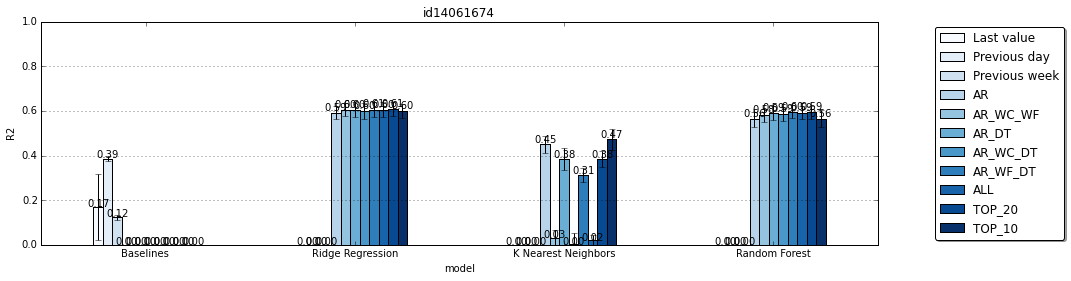

In [14]:
for sensor_id in validation_df.columns.levels[0]:
        
    err = validation_df.groupby(level=['dataset', 'model']).std()[sensor_id]['R2'].unstack(0)
            
    ax = validation_df.groupby(level=['dataset', 'model']).mean()[sensor_id]['R2'].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel('R2')
    plt.legend(loc='right', bbox_to_anchor=(1.23, 0.5), ncol=1, fancybox=True, shadow=True)

### Errors only for specific prediction horizon

In [388]:
"""
for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.loc[20][sensor_id]['R2'].unstack(0).plot(
        kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)
"""

'\nfor sensor_id in validation_df.columns.levels[0]:\n    ax = validation_df.loc[20][sensor_id][\'R2\'].unstack(0).plot(\n        kind=\'bar\', figsize=(15,4), rot=0, title=sensor_id, colormap=\'Blues\', ylim=(0,1))\n    \n    for p in ax.patches:\n        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha=\'center\')\n    \n    plt.gca().yaxis.grid(True)\n    ax.set_ylabel(measure)\n    plt.legend(loc=\'right\', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)\n'

## Evaluation Scores for Each Horizon

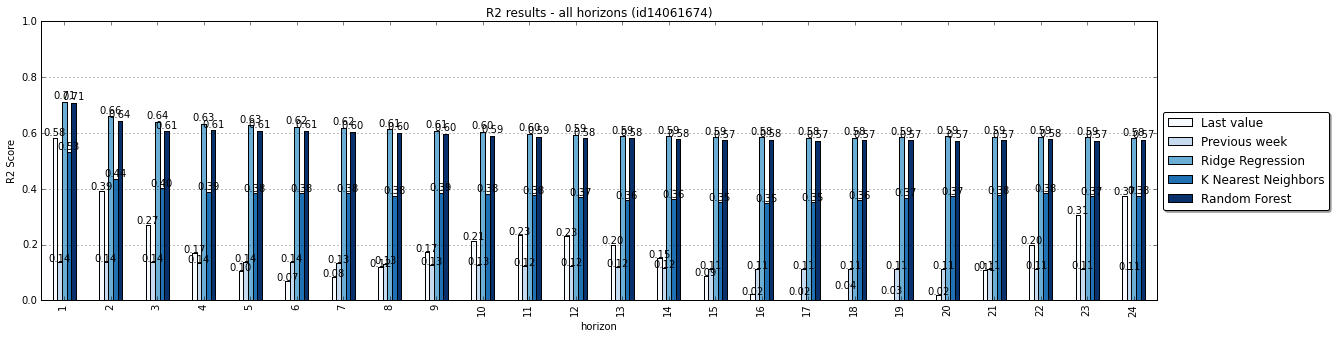

In [18]:
ax = validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061674']['R2'][['Last value', 'Previous week']].join(
    validation_df.xs(["TOP_20"], level=["dataset"]).unstack()['id14061674']['R2']).plot(
    kind='bar', figsize=(20,5), title='R2 results - all horizons (id14061674)', ylim=(0,1), colormap='Blues')

for p in ax.patches:
    ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')

ax.yaxis.grid()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.), ncol=5, fancybox=True, shadow=True)
#plt.legend(loc=4)
plt.ylabel('R2 Score')

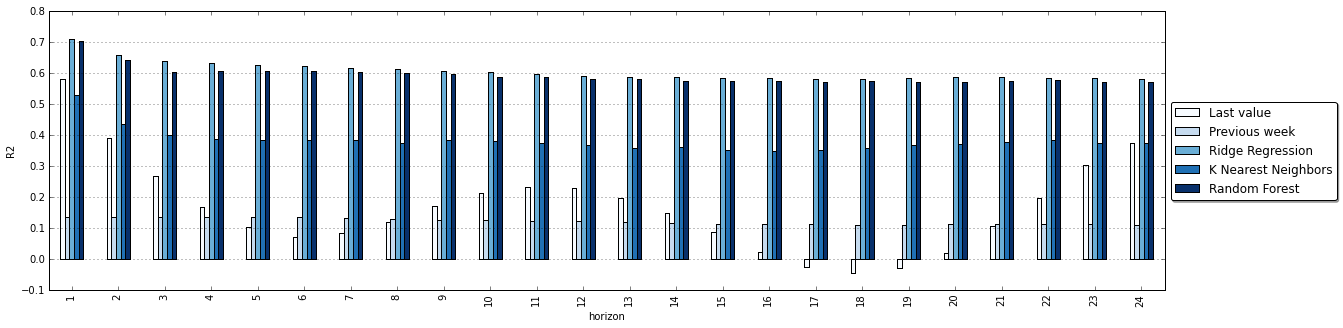

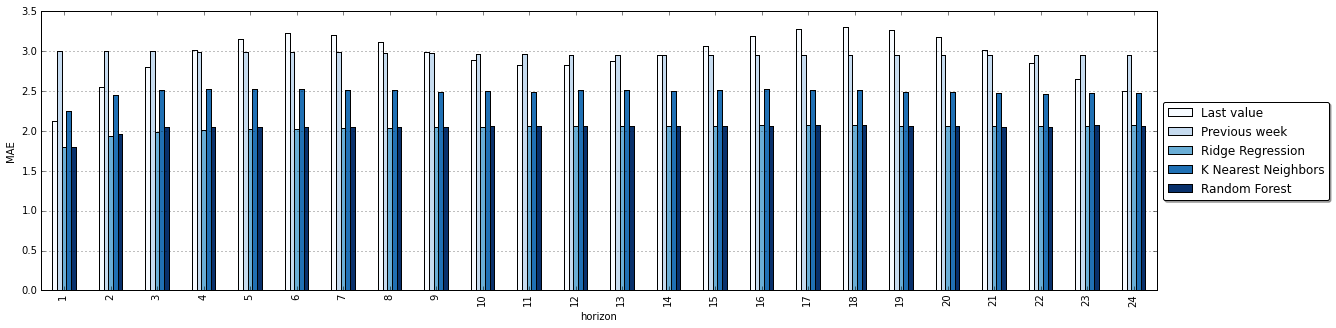

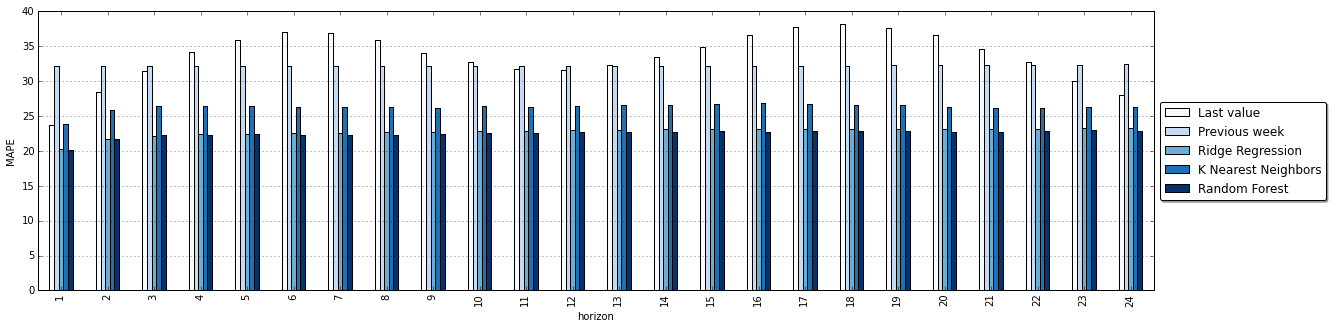

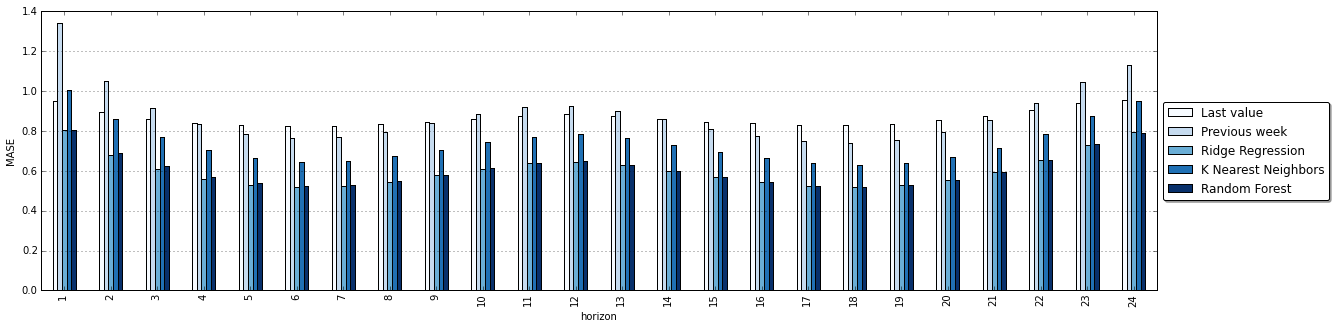

In [17]:
for measure in validation_df.columns.levels[1]:
    
    ax = validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061674'][measure][['Last value', 'Previous week']].join(
        validation_df.xs(["TOP_20"], level=["dataset"]).unstack()['id14061674'][measure]).plot(
        kind='bar', figsize=(20,5), colormap='Blues')
    
    ax.yaxis.grid()   
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
    plt.ylabel(measure)
 

## Average Score by Sensors and Horizons

In [16]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean()

error metric                                   R2       MAE       MAPE  \
dataset             model                                                
Last value          Baselines            0.561509  1.675817  29.038490   
Previous day        Baselines            0.399188  2.035682  41.442958   
Previous week       Baselines            0.655598  1.569669  30.650789   
Measurement average Baselines            0.176525  3.042106  72.821162   
AR                  Ridge Regression     0.812825  1.276349  27.640770   
                    K Nearest Neighbors  0.785566  1.356553  29.801900   
                    Random Forest        0.823768  1.255085  29.553442   
SELECTED            Ridge Regression     0.755056  1.611357  39.967885   
                    K Nearest Neighbors  0.781093  1.401275  30.995457   
                    Random Forest        0.842835  1.194789  26.340880   

error metric                                 MASE  
dataset             model                          
Last value          Baselines            0.728761  
Previous day        Baselines            0.939339  
Previous week       Baselines            0.724327  
Measurement average Baselines            1.378100  
AR                  Ridge Regression     0.575318  
                    K Nearest Neighbors  0.616033  
                    Random Forest        0.565061  
SELECTED            Ridge Regression     0.711889  
                    K Nearest Neighbors  0.631593  
                    Random Forest        0.538496

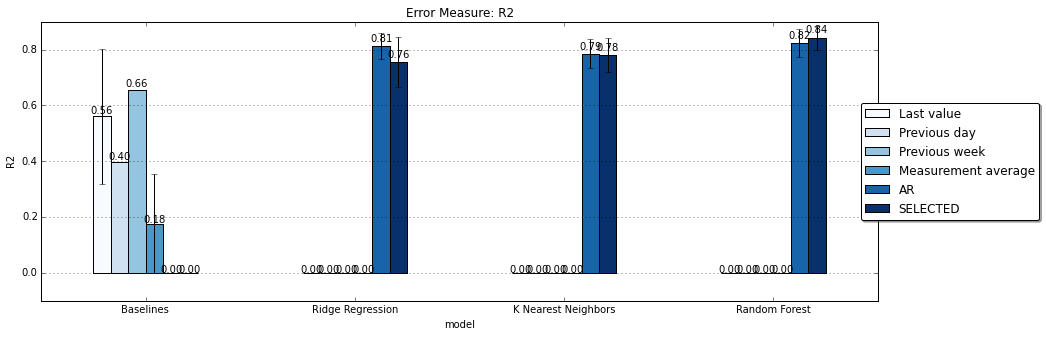

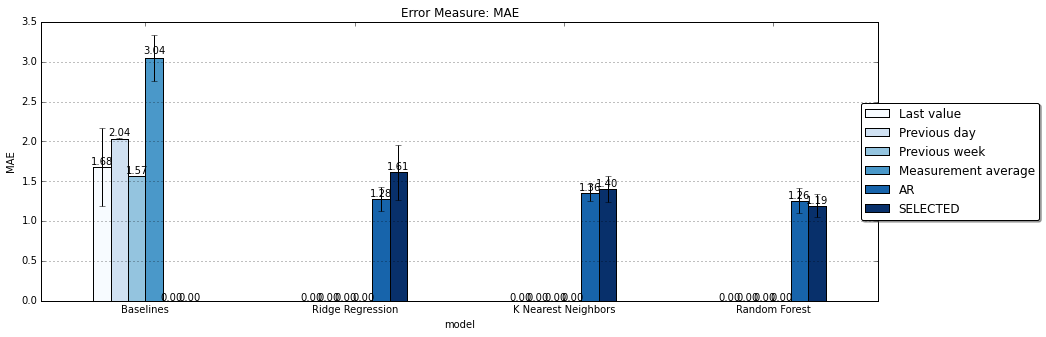

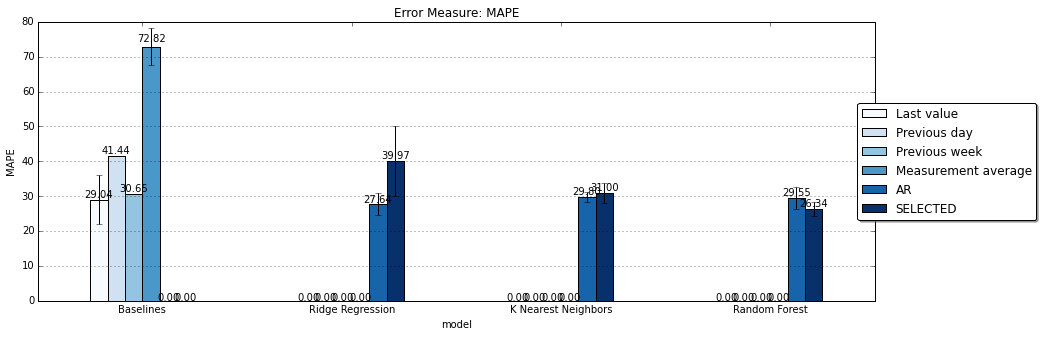

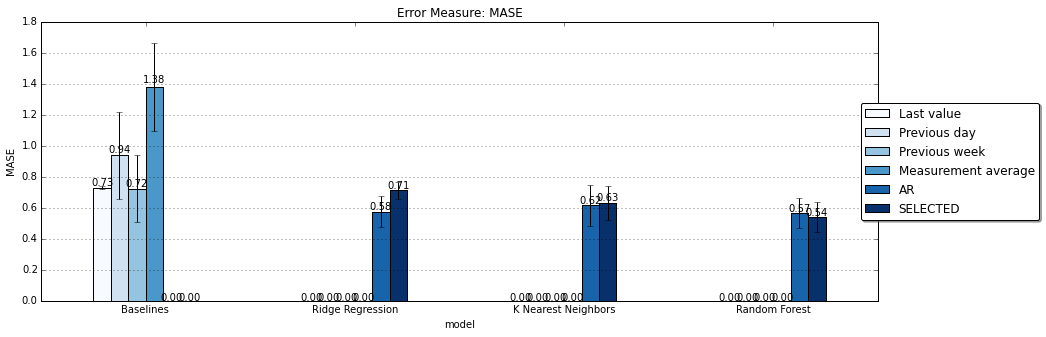

In [18]:
for measure in validation_df.columns.levels[1]:

    err = ax = validation_df.groupby(level=['dataset', 'model']).std().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0)
    
    ax = validation_df.groupby(level=['dataset', 'model']).mean().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,5), rot=0, title="Error Measure: {}".format(measure), colormap='Blues')

    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

NOTE: From this, it looks like weather does not help to improve accuracy. Date time features are the most important.